In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm


from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'dejavuserif' 
rcParams['figure.figsize'] = (10, 7)
rcParams['figure.dpi'] = 300
rcParams['axes.grid'] = True
rcParams['font.size'] = 14
# rcParams

In [173]:
with open("exp3.csv") as f:
    exp3 = pd.read_csv(f)
    
exp3.t += 273.15
exp3.sort_values("t", inplace=True)
exp3.reset_index(inplace=True)
exp3.drop(columns=("index"), inplace=True)
exp3export = exp3.copy()
exp3.n *= 1e7 # erg
# exp3

### оценка погрешностей
$\Delta U = 0.01, \; \Delta I = 0.01 \; \Rightarrow \Delta N \approx N \sqrt{\varepsilon_U^2 + \varepsilon_I^2}$  
$\Delta \log{N} = \dfrac{\Delta N}{N}$  
$\Delta T = 10$ K$, \; \Delta \log{T} = \dfrac{\Delta T}{T}$

In [179]:
exp3err = pd.DataFrame()
exp3err["v_rerr"] = 0.01 / exp3.v
exp3err["i_rerr"] = 0.01 / exp3.I
exp3err["n_rerr"] = np.sqrt(exp3err.v_rerr ** 2 + exp3err.i_rerr ** 2)
exp3err["n_err"] = exp3.n * exp3err.n_rerr

exp3lerr = pd.DataFrame()
exp3lerr["n_err"] = exp3err.n_err / exp3.n
exp3lerr["t_err"] = 10 / exp3.t
exp3lerr

,n_err,t_err
0,0.021993,0.009318
1,0.020025,0.008236
2,0.018369,0.007904
3,0.017262,0.007277
4,0.016293,0.006910
5,0.015387,0.006583
6,0.014687,0.006377
7,0.014054,0.006161
8,0.013492,0.006049
9,0.012975,0.005837


# Проверка закона Стефана-Больцмана

In [180]:
exp3log = exp3.copy()
exp3log.drop(columns=['v', 'I'], inplace=True)
exp3log = np.log(exp3log[['t', 'n']])

[  3.90982586 -11.72641154] [0.05930905 0.44654105]


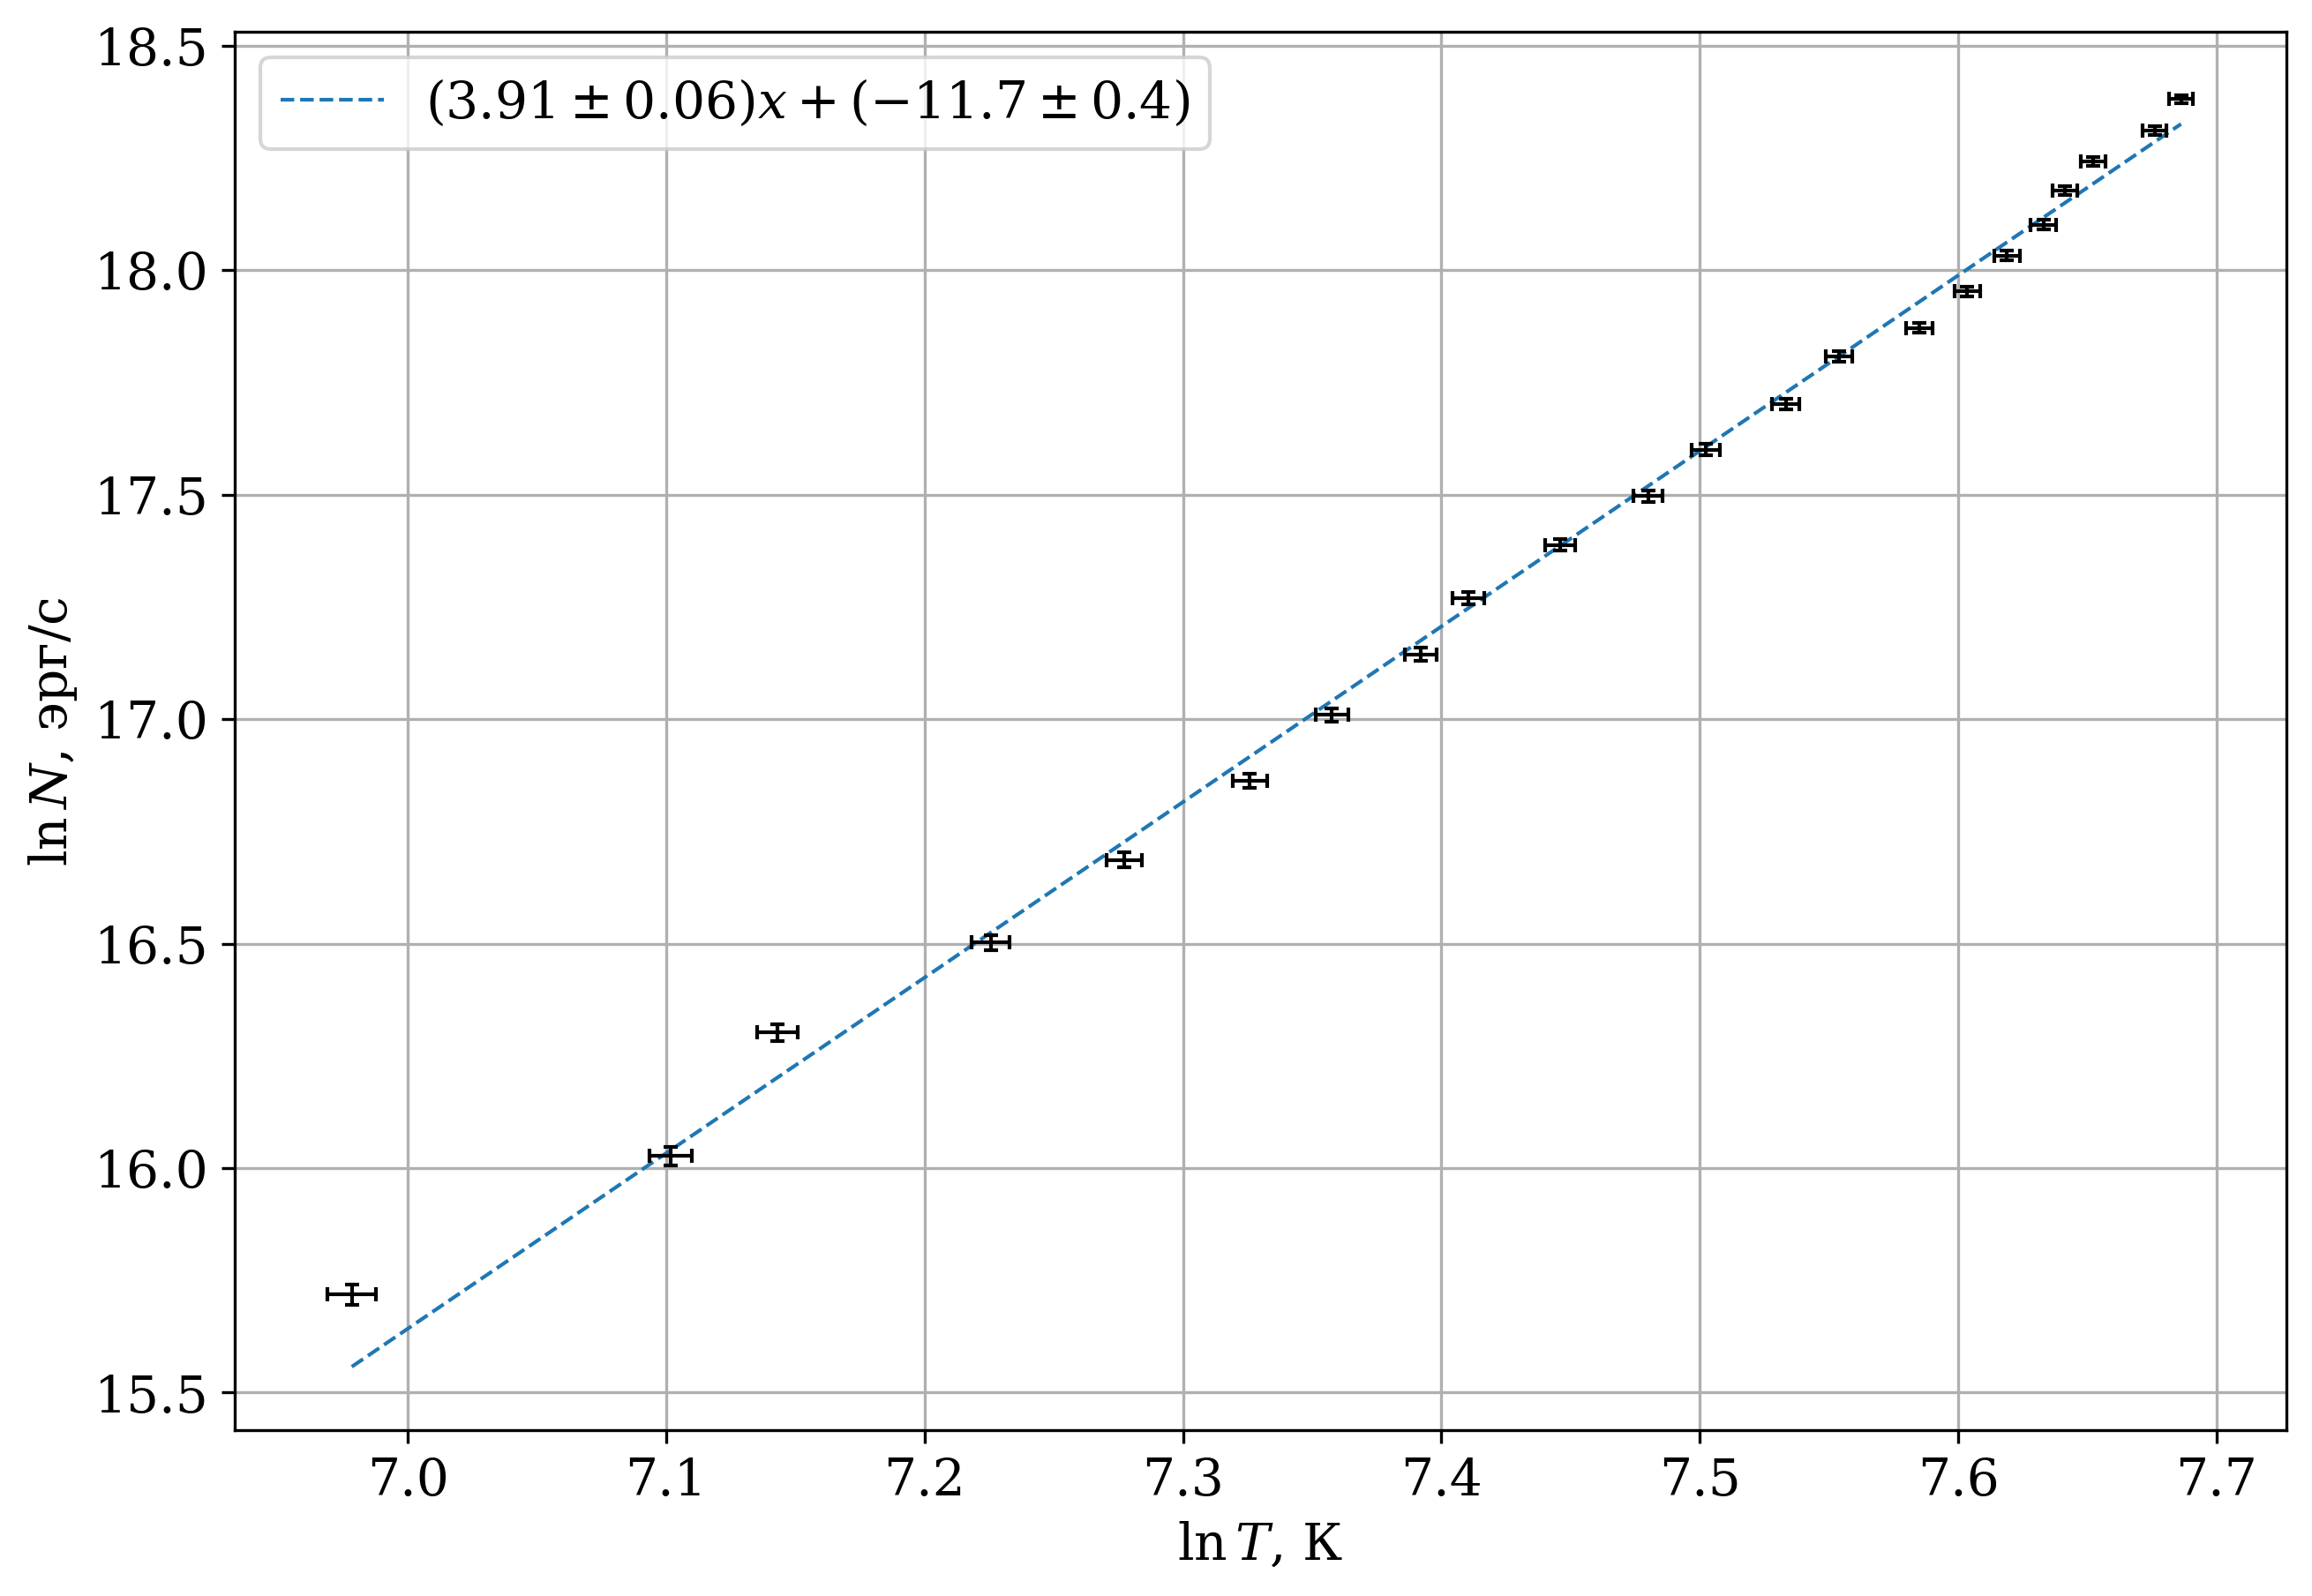

In [195]:
plt.figure()
plt.xlabel(r"$\ln T$, К")
plt.ylabel(r"$\ln N$, эрг/c")

# plt.scatter(exp3log.t, exp3log.n)
plt.errorbar(exp3log.t, exp3log.n, exp3lerr.n_err, exp3lerr.t_err, "none",  capsize=2, lw=1, color="black", zorder=3)
arg, cov =  np.polyfit(exp3log.t, exp3log.n, 1, w=1/exp3lerr.n_err, cov=True)
err = np.sqrt(np.diagonal(cov))
print(arg, err)

f = np.poly1d(arg)
plt.plot(exp3log.t, f(exp3log.t), lw=1, ls='--', label= f"$({arg[0]:.2f} \\pm {err[0]:.2f}) x + ({arg[1]:.1f} \\pm {err[1]:.1f})$")

plt.legend()

plt.savefig("plot3.pdf")

# Нахождение постоянной Стефана-Больцмана $\sigma$ и постоянной Планка $h$

In [256]:
S = 0.36 # cm2
N = np.array(exp3.n) #* 1e5 # erg / c
T = np.array(exp3.t)
def eps(t):
    return 0.209 + 0.04 / 300 * (t - 1700)

sigmas = N / (eps(T) * S * T ** 4)
ss = sigmas[9:16]
N_err = np.array(exp3lerr["n_err"])
sigmas_err = sigmas * np.sqrt(4 * ( 10 / T) ** 2 + N_err ** 2)
print(np.round(ss.mean()*1e5, 1), np.round(ss.std()*1e5, 1))
print(*T[9:16].astype(int), sep=" & ")
print(*np.round(sigmas[9:16]*1e5, 2), sep=" & ")
print(*np.round(sigmas_err[9:16]*1e5, 2), sep=" & ")
T[9:16]

4.8 0.4
1713 & 1772 & 1812 & 1869 & 1908 & 1968 & 2005
5.45 & 5.11 & 5.06 & 4.79 & 4.79 & 4.37 & 4.31
0.1 & 0.09 & 0.08 & 0.08 & 0.07 & 0.07 & 0.06


array([1713.15, 1772.15, 1812.15, 1869.15, 1908.15, 1968.15, 2005.15])

In [236]:
a = np.exp(arg[1])
sigma = a / S 
sigma

2.243787248396105e-05

### Погрешности методов

$\Delta \sigma = \sigma \sqrt{\varepsilon_N^2 + 4 \varepsilon_T^2}$

In [242]:
def plank(x):
    return np.cbrt(2 * np.pi ** 5 * (1.38049e-16) ** 4 / (15 * (2.997928e10) ** 2 * x))

planks = plank(sigmas[T > 1700])
planks.mean() * 1e27, planks.std() * 1e27

(7.102454814976427, 0.1814018869320158)